<a href="https://colab.research.google.com/github/MilanBandara/FYP/blob/main/UNET_for_Deblur_PNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Drive
from google.colab import drive
import numpy as np
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
!cp -r "generated_y" "/content/"

^C


#Creating the data generator

In [3]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(img_dir+image_name,0)
            image = cv2.resize(image,(256,256))
            # print("Image - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def load_msk(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
            # print("before - ",image.shape)
            image = to_categorical(image, num_classes=4)
            # print("After - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size

#Making the data generator

In [4]:
train_X_dir = "/content/drive/MyDrive/generated_x/"
#train_X_dir = "/content/generated_x/"
train_Y_dir = "/content/drive/MyDrive/generated_y/"
#train_Y_dir = "/content/generated_y/"

train_X_list=sorted(os.listdir(train_X_dir))
train_X_list = train_X_list[:5000]
train_Y_list = sorted(os.listdir(train_Y_dir))
train_Y_list = train_Y_list[:5000]

val_X_dir = "/content/drive/MyDrive/validation_y/"
val_Y_dir = "/content/drive/MyDrive/validation_x/"
val_X_list = sorted(os.listdir(val_X_dir))
val_X_list = val_X_list[:100]
val_Y_list = sorted(os.listdir(val_Y_dir))
val_Y_list = val_Y_list[:100]

In [5]:
batch_size = 8

train_img_datagen = imageLoader(train_X_dir, train_X_list,
                                train_Y_dir, train_Y_list, batch_size)

val_img_datagen = imageLoader(val_X_dir, val_X_list,
                                val_Y_dir, val_Y_list, batch_size)

#Verifying the generator

In [6]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

In [ ]:
print(img.shape)

(8, 256, 256)


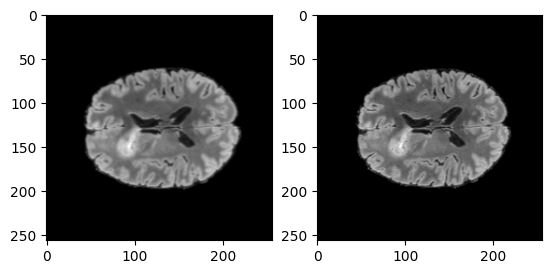

In [7]:
index = 6
plt.subplot(121)
plt.imshow(img[index],cmap="gray")
plt.subplot(122)
plt.imshow(msk[index],cmap="gray")

In [ ]:
print(img.shape)

(8, 256, 256)


#Visualizing the loaded images

##Attention blocks

In [8]:

# https://youtu.be/L5iV5BHkMzM
"""

Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf

Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)

Note: Batch normalization should be performed over channels after a convolution,
In the following code axis is set to 3 as our inputs are of shape
[None, height, width, channel]. Channel is axis=3.

Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


##Attention UNET

In [9]:
def attention_unet_model(batch_norm = True):
#Build the model
    inputs = Input((240, 240, 4))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.4)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5) #deepest conv block

    #Expansive path
    #create a gating signal
    gating_6 = gating_signal(c5, 128, batch_norm = True) #feed this and c4 to attention block
    #getting the output from attention block by feeding gating signal and c4
    att_6 = attention_block(c4, gating_6, 128)
    #Conv2DTranspose the deepest block c5
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) #this is correct
    #concatanate the upsampled block and the the output from the attention block
    u6 = concatenate([u6, att_6])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    gating_7 = gating_signal(c6, 64, batch_norm = True)
    att_7 = attention_block(c3,gating_7,64)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, att_7])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    gating_8 = gating_signal(c7, 32, batch_norm = True)
    att_8 = attention_block(c2,gating_8,32)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, att_8])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    gating_9 = gating_signal(c8, 16, batch_norm = True)
    att_9 = attention_block(c1,gating_9,16)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, att_9], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(4, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

##Basic UNET model

In [10]:
def multi_unet_model():
#Build the model
    inputs = Input((256, 256, 1))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.4)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [11]:
###############################################################
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)

#Defining loss metrics (IOU)

In [12]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

# # Typical tf.keras API usage
# import tensorflow as tf
# from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss

In [13]:

# import segmentation_models_3D as sm
# # dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# # total_loss = dice_loss + (1 * focal_loss)

##Defining focal loss

In [14]:
import tensorflow as tf

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=4.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        """
        Inputs and targets should be of shape (batch_size, num_classes, height, width)
        """

        # Calculate the cross-entropy loss
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Calculate the scaling factor
        pt = tf.math.exp(-ce_loss)
        scaling_factor = (1 - pt) ** self.gamma

        # Calculate the Focal loss
        focal_loss = scaling_factor * ce_loss

        # Return the average Focal loss over the batch
        return tf.reduce_mean(focal_loss)

##Creating a Checkpoint

In [15]:

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/deblur_more_data/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
import math
n_batches = 1051 / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=10*n_batches)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

IMG_HEIGHT = 256
IMG_WIDTH  =  256
IMG_CHANNELS = 4

def get_model():
    return multi_unet_model()

model = get_model()
model.compile(optimizer=Adam(), loss=MeanSquaredError())
#model.compile(optimizer='adam', loss=ca, metrics=[accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [17]:
steps_per_epoch = len(train_X_list)//batch_size
val_steps_per_epoch = len(val_X_list)//batch_size

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=106,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[cp_callback],
                    shuffle=False)

Epoch 1/106
 11/625 [..............................] - ETA: 30:22 - loss: 4840.0903

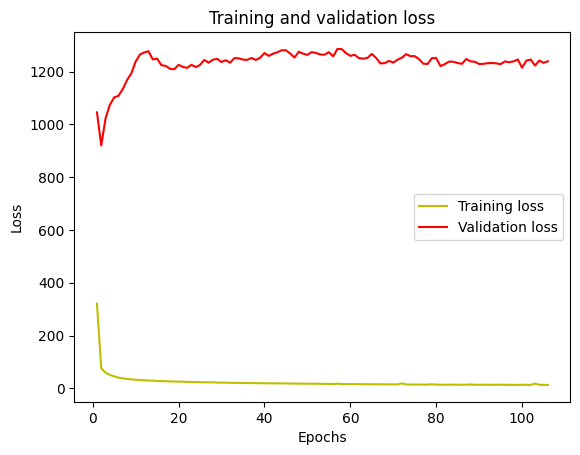

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for i in history.history.items():
  print(i)

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/deblur_results/training_loss.npy",np.array(loss))
np.save("/content/drive/MyDrive/deblur_results/val_loss.npy",np.array(val_loss))
np.save("/content/drive/MyDrive/focal5/training_jaccard.npy",np.array(acc))
np.save("/content/drive/MyDrive/focal5/val_jaccard.npy",np.array(val_acc))
np.save("/content/drive/MyDrive/focal5/epochs.npy",range(1, len(np.array(loss)) + 1))

In [ ]:
# loss_1 = np.load("/content/drive/MyDrive/small_UNET_models/training_loss.npy")
# epoch_1 = np.load("/content/drive/MyDrive/small_UNET_models/epochs.npy")

# plt.plot(epoch_1, loss_1, 'y', label='Training loss')
# # plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [ ]:
img, msk = val_img_datagen.__next__()

##making predictions on test dataset

1/1 [==============================] - 0s 23ms/step
(256, 256)
(256, 256)


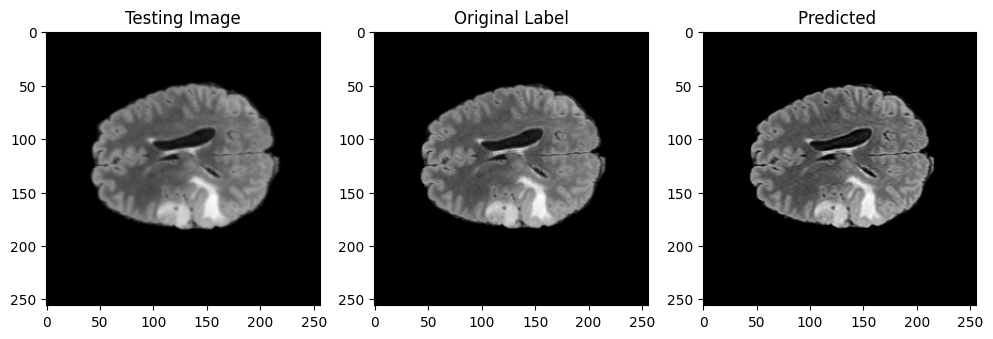

In [ ]:
img, msk = val_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img)-1)#6 is good
# test_img_number = 6
test_img = img[test_img_number]
ground_truth=msk[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
prediction = np.reshape(prediction,(256,256))
print(test_img.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray') #only the first channel is displayed

plt.subplot(132)
plt.title('Original Label')
plt.imshow(ground_truth, cmap='gray')

plt.subplot(133)
plt.title('Predicted ')
plt.imshow(prediction, cmap='gray')
plt.show()

# focal_loss = FocalLoss()
# loss = focal_loss.call(ground_truth, predicted_img)
# print(loss)
# # IOU = jacard_coef(ground_truth, predicted_img)
# # print(IOU)

##Loading the last checkpoint

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss= FocalLoss(), metrics=[jacard_coef])

# Load the previously saved weights
model.load_weights("/content/drive/MyDrive/deblur_more_data/cp-0106.ckpt")

In [ ]:
img, msk = val_img_datagen.__next__()

1/1 [==============================] - 0s 22ms/step
(256, 256)
(256, 256)


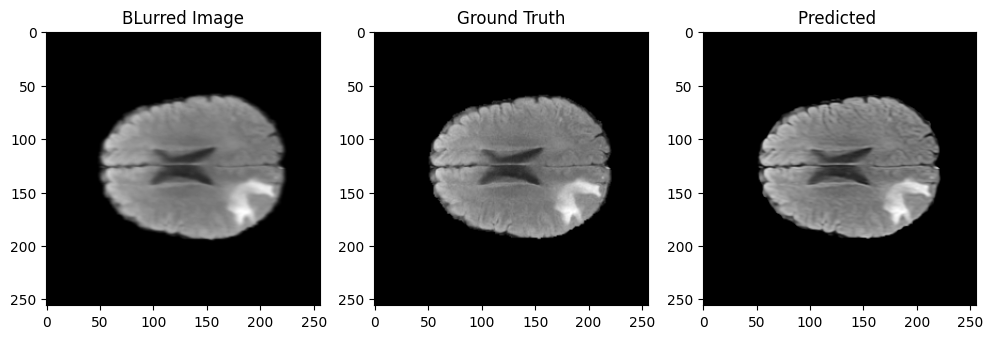

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
#img, msk = val_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img)-1)#6 is good
# test_img_number = 6
test_img = img[test_img_number]
ground_truth=msk[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
prediction = np.reshape(prediction,(256,256))
print(test_img.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('BLurred Image')
plt.imshow(test_img, cmap='gray') #only the first channel is displayed

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='gray')

plt.subplot(133)
plt.title('Predicted ')
plt.imshow(prediction, cmap='gray')
plt.show()

# focal_loss = FocalLoss()
# loss = focal_loss.call(ground_truth, predicted_img)
# print(loss)
# # IOU = jacard_coef(ground_truth, predicted_img)
# # print(IOU)

##t1n channel can be dropped since it doest carry much data

# Start training from a checkpoint

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=55,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[cp_callback],
                    shuffle=False)